In [1]:
import cv2
import sys
import math
import numpy as np
import face_recognition
from PIL import Image,ImageDraw
from collections import defaultdict
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('..')
from config import webPath

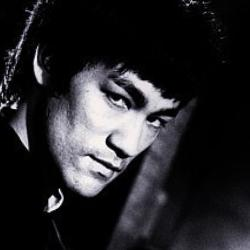

In [2]:
img_path = webPath + '/0000045/011.jpg'
img_array = cv2.imread(img_path)
img_col = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
Image.fromarray(img_col)

[(67, 182, 196, 53)]
{'chin': [(60, 82), (52, 98), (48, 115), (47, 131), (49, 148), (54, 162), (60, 177), (68, 189), (80, 196), (92, 200), (107, 198), (121, 194), (137, 186), (151, 175), (162, 162), (169, 145), (172, 129)], 'left_eyebrow': [(82, 69), (91, 67), (102, 69), (111, 73), (119, 80)], 'right_eyebrow': [(132, 88), (142, 89), (152, 93), (159, 99), (163, 107)], 'nose_bridge': [(120, 100), (117, 110), (114, 120), (111, 130)], 'nose_tip': [(96, 136), (100, 140), (105, 143), (111, 144), (117, 145)], 'left_eye': [(85, 88), (93, 87), (100, 90), (104, 97), (97, 94), (90, 92)], 'right_eye': [(130, 109), (138, 107), (145, 110), (150, 117), (143, 115), (136, 112)], 'top_lip': [(76, 152), (87, 151), (96, 151), (102, 155), (108, 156), (115, 162), (118, 170), (116, 169), (106, 162), (99, 160), (94, 158), (79, 153)], 'bottom_lip': [(118, 170), (109, 176), (101, 176), (94, 173), (88, 170), (81, 162), (76, 152), (79, 153), (92, 161), (98, 164), (104, 167), (116, 169)]} 

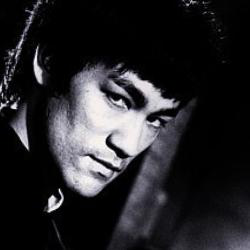

In [3]:
image = face_recognition.load_image_file(img_path)
face_locations = face_recognition.face_locations(image)
print(face_locations)
face_landmarks_list = face_recognition.face_landmarks(image, model="large")
face_landmarks_dict = face_landmarks_list[0]
print(face_landmarks_dict, end=" ")
Image.fromarray(image)

In [4]:
def visualize_landmark(image_array, landmarks):
    """ plot landmarks on image
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return: plots of images with landmarks on
    """
    origin_img = Image.fromarray(image_array)
    draw = ImageDraw.Draw(origin_img)
    for facial_feature in landmarks.keys():
        draw.point(landmarks[facial_feature])
    imshow(origin_img)

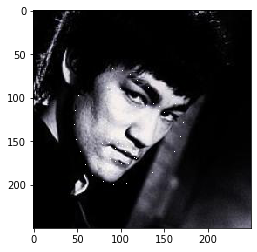

In [5]:
visualize_landmark(image_array=image,landmarks=face_landmarks_dict)
plt.show()

In [6]:
def align_face(image_array, landmarks):
    """ align faces according to eyes position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    rotated_img:  numpy array of aligned image
    eye_center: tuple of coordinates for eye center
    angle: degrees of rotation
    """
    # get list landmarks of left and right eye
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    # calculate the mean point of landmarks of left and right eye
    left_eye_center = np.mean(left_eye, axis=0).astype("int")
    right_eye_center = np.mean(right_eye, axis=0).astype("int")
    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                  (left_eye_center[1] + right_eye_center[1]) // 2)
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1)
    rotated_img = cv2.warpAffine(image_array, rotate_matrix, (image_array.shape[1], image_array.shape[0]))
    return rotated_img, eye_center, angle

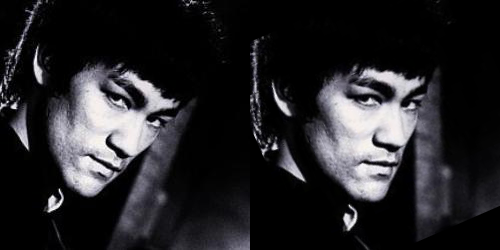

In [7]:
aligned_face, eye_center, angle = align_face(image_array=image, landmarks=face_landmarks_dict)
Image.fromarray(np.hstack((image,aligned_face)))

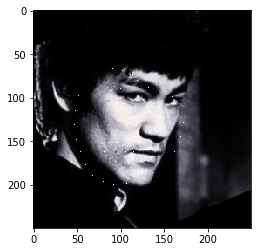

In [8]:
visualize_landmark(image_array=aligned_face,landmarks=face_landmarks_dict)
plt.show()

In [9]:
def rotate(origin, point, angle, row):
    """ rotate coordinates in image coordinate system
    :param origin: tuple of coordinates,the rotation center
    :param point: tuple of coordinates, points to rotate
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated coordinates of point
    """
    x1, y1 = point
    x2, y2 = origin
    y1 = row - y1
    y2 = row - y2
    angle = math.radians(angle)
    x = x2 + math.cos(angle) * (x1 - x2) - math.sin(angle) * (y1 - y2)
    y = y2 + math.sin(angle) * (x1 - x2) + math.cos(angle) * (y1 - y2)
    y = row - y
    return int(x), int(y)

In [10]:
def corp_face(image_array, landmarks):
    """ crop face according to eye,mouth and chin position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    cropped_img: numpy array of cropped image
    """

    eye_landmark = np.concatenate([np.array(landmarks['left_eye']),
                                   np.array(landmarks['right_eye'])])
    eye_center = np.mean(eye_landmark, axis=0).astype("int")
    lip_landmark = np.concatenate([np.array(landmarks['top_lip']),
                                   np.array(landmarks['bottom_lip'])])
    lip_center = np.mean(lip_landmark, axis=0).astype("int")
    mid_part = lip_center[1] - eye_center[1]
    top = eye_center[1] - mid_part * 30 / 35
    bottom = lip_center[1] + mid_part

    w = h = bottom - top
    x_min = np.min(landmarks['chin'], axis=0)[0]
    x_max = np.max(landmarks['chin'], axis=0)[0]
    x_center = (x_max - x_min) / 2 + x_min
    left, right = (x_center - w / 2, x_center + w / 2)

    pil_img = Image.fromarray(image_array)
    left, top, right, bottom = [int(i) for i in [left, top, right, bottom]]
    cropped_img = pil_img.crop((left, top, right, bottom))
    cropped_img = np.array(cropped_img)
    return cropped_img, left, top

In [11]:
def rotate_landmarks(landmarks, eye_center, angle, row):
    """ rotate landmarks to fit the aligned face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param eye_center: tuple of coordinates for eye center
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated_landmarks with the same structure with landmarks, but different values
    """
    rotated_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            rotated_landmark = rotate(origin=eye_center, point=landmark, angle=angle, row=row)
            rotated_landmarks[facial_feature].append(rotated_landmark)
    return rotated_landmarks

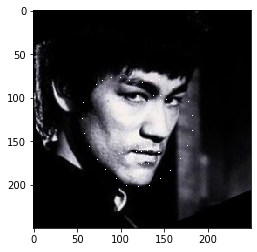

In [12]:
rotated_landmarks = rotate_landmarks(landmarks=face_landmarks_dict,
                                         eye_center=eye_center, angle=angle, row=image.shape[0])
visualize_landmark(image_array=aligned_face,landmarks=rotated_landmarks)
plt.show()

In [13]:
cropped_face, left, top = corp_face(image_array=aligned_face, landmarks=rotated_landmarks)
Image.fromarray(cropped_face)
print(np.array(cropped_face).shape)
# Image.fromarray(image)

(183, 183, 3)


In [17]:
def transfer_landmark(landmarks, left, top):
    """transfer landmarks to fit the cropped face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param left: left coordinates of cropping
    :param top: top coordinates of cropping
    :return: transferred_landmarks with the same structure with landmarks, but different values
    """
    transferred_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            transferred_landmark = (landmark[0] - left, landmark[1] - top)
            transferred_landmarks[facial_feature].append(transferred_landmark)
    return transferred_landmarks

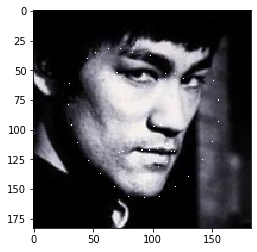

In [15]:
transferred_landmarks = transfer_landmark(landmarks=rotated_landmarks, left=left, top=top)
visualize_landmark(image_array=cropped_face,landmarks=transferred_landmarks)
plt.show()

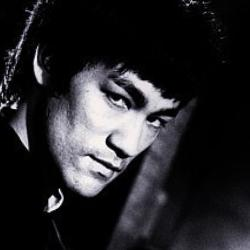

In [16]:
Image.fromarray(img_col)